<a href="https://colab.research.google.com/github/vilsonrodrigues/PegasusProject/blob/master/Pegasus_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando bibliotecas

https://teses.usp.br/teses/disponiveis/85/85133/tde-31102011-101817/publico/2011AffonsoMapas.pdf

In [0]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go

Leitura do CSV

In [4]:
tab = pd.read_csv("https://raw.githubusercontent.com/vilsonrodrigues/PegasusProject/master/Data%20Bases/submissoesDiferetesEIguaisA100.csv")
tab = tab.drop(columns={"Unnamed: 0"})
tab.head(1)

,idAluno,nota,situacao,submissões diferentes e iguais a 100% semana 1,submissões diferentes e iguais a 100% semana 2,submissões diferentes e iguais a 100% semana 3,submissões diferentes e iguais a 100% semana 4,submissões diferentes e iguais a 100% semana 5,submissões diferentes e iguais a 100% semana 6,submissões diferentes e iguais a 100% semana 7,submissões diferentes e iguais a 100% semana 8,submissões diferentes e iguais a 100% semana 9,submissões diferentes e iguais a 100% semana 10,submissões diferentes e iguais a 100% semana 11,submissões diferentes e iguais a 100% semana 12,submissões diferentes e iguais a 100% semana 13,submissões diferentes e iguais a 100% semana 14,submissões diferentes e iguais a 100% semana 15,submissões diferentes e iguais a 100% semana 16,submissões diferentes e iguais a 100% semana 17,submissões diferentes e iguais a 100% semana 18
0,5991cb910be9d42f2f68b906,7.9,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Instalando a SOM

In [1]:
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.2-cp36-none-any.whl size=7263 sha256=072118d61fe2f66bc6dd5af72addc235746945b762a510f24aa6fb1efe02a06b
  Stored in directory: /root/.cache/pip/wheels/4a/46/e1/605a71c70f6a19f16b44fc309f6557127591c69969476cf5d1
Successfully built minisom


Selecionando o df com o campo nota não nulo

In [0]:
tab = tab[tab["nota"] != '-']

Convertendo notas para float

In [0]:
tab["nota"] = tab["nota"].astype(float)

Separando o X treino

In [0]:
X_train = tab.iloc[:, 3:].values

Escolhendo o alvo, que será a nota final

In [8]:
Y_train = tab.iloc[:,1].values
Y_train

array([7.9, 7.9, 7.9, ..., 0. , 0. , 0. ])

Criando o modelo da SOM

In [0]:
tamanhoXdaRede = 20; 
tamanhoYdaRede = 20; 
quantidadeCaracteristicas = 18

from minisom import MiniSom
som = MiniSom(x = tamanhoXdaRede, y = tamanhoYdaRede, input_len = quantidadeCaracteristicas, sigma = 1.0, learning_rate = 0.4)

Treinando a rede SOM

In [0]:
som.train_random(data = X_train, num_iteration = 100000, verbose = False) 
#se verbose True ele imprime a cada iteração
#como eu uso o train_random tanto faz a sequência em que os dados estão

Mapa de distância dos pesos

In [0]:
som.distance_map()

Obtem o vetor de pesos da rede treinada 

In [0]:
pesos = som.get_weights()

Criando uma lista com as semanas 

In [13]:
colunas = []
for i in range(1,19):
  colunas.append("Semana "+str(i))
print(colunas)

['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4', 'Semana 5', 'Semana 6', 'Semana 7', 'Semana 8', 'Semana 9', 'Semana 10', 'Semana 11', 'Semana 12', 'Semana 13', 'Semana 14', 'Semana 15', 'Semana 16', 'Semana 17', 'Semana 18']


Montando matrizes para total de ocorrências, uma para aprovados e outra para reprovados

In [0]:
# matriz de zeros para contador de reprovados 
MContRe = np.zeros((tamanhoXdaRede,tamanhoYdaRede))
# matriz de zeros para contador de aprovados 
MContAp = np.zeros((tamanhoXdaRede,tamanhoYdaRede))
# matriz de zeros para o número total de alunos
MContT = np.zeros((tamanhoXdaRede,tamanhoYdaRede))

cont = 0; 

for x in X_train: 
  pos = som.winner(x)
  if (Y_train[cont] < 5): #Reprovado 
    MContRe[pos] += 1
  if (Y_train[cont] >= 5): #Aprovado 
    MContAp[pos] += 1    
  MContT[pos] += 1
  cont= cont+1

Função para normalizar dados

In [0]:
def normalizaDados(data):
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()
  dt = sc.fit_transform(data)
  return dt

Função de criação de gráfico de superfície

In [0]:
def chamaGraficoDeSuperficie(data):
  z_data = normalizaDados(data)
  fig = go.Figure(data=[go.Surface(z=z_data)])
  fig.update_layout(title="Gráfico de superfície - Reprovados", autosize=False,
                    width=750, height=600,
                    margin=dict(l=65, r=50, b=65, t=90))
  fig.show()  

Função para chamar gráfico de pizza 

In [0]:
def chamaGraficoDePizzaDeSituacoes():
  fig = plt.figure(figsize=(10,5))
  cont = 1;
  for i in range(len(MContT)):
    for j in range(len(MContT)):
      plt.subplot(tamanhoXdaRede,tamanhoYdaRede,cont)
      cont=cont+1
      sizes = [MContAp[i][j],MContT[i][j]-MContAp[i][j]]
      plt.pie(sizes)
  plt.set_title("Gráfico de % de aprovados e reprovados em cada neurônio")
  plt.show()

Função para exibir atributos de um neurônio específico 

In [0]:
def exibeNeuronio(linha,coluna): 
  fig = plt.figure()
  ax = fig.add_axes([0.1,0.1,1.5,1.5])
  ax.bar(colunas, pesos[linha,coluna,:], color="y")
  plt.xticks(rotation=90)
  ax.set_title("Especificação do Neurônio " + str(linha) + "," + str(coluna))
  plt.show()

Função para consultar a proporção de aprovados e reprovados e retornar uma cor 

In [0]:
def consultaProporcao(posAnt):
  div = (MContRe[posAnt] / MContT[posAnt])
  if(div > 0.20 ):
    return "r"
  elif(div < 0.10 ):
    return "g"
  else:
    return "#FFFF00"
#As proporções escolhidas foram: se existe até 10% de reprovados você está numa região segura, a cor escolhida é verde
#se você está numa região entre 10% a 20% de reprovados, então você está amarelo, seria um alerta
#se você está cima de 20% nesse neurônio você está vermelho

Função para inserir estados no node

In [0]:
def insereAtributo(G, pos, cont):
  var = []
  semanas = []
  try: 
    atributos = nx.get_node_attributes(G, "semana")
    for i in atributos[pos]:
        var.append(i)
  except:
    pass
  for i in var:
       semanas.append(i)
  semanas.append(cont)   
  G.nodes[pos]["semana"] = semanas
  return G

#O objetivo é fazer uma lista de atributos, sendo que irá conter as semanas que caíram naquele neurônio
#eu faço uma try catch para verificar se está vazio o atributo desse neuronio, como não existe uma função expecifica para verificar isso
#acabo tendo que utiliza-lo. Se não estiver vazio ele recebe a lista e depois faz a consulta desse valor
#depois recebe o atual e insere 

Função para exibir qual foi a semana que caiu no neurônio

In [0]:
def verificaSemanasNoNeuronio(G,x,y):
  print("Semana(s) que caíram no neurônio " + str(G.nodes[(x,y)]["semana"]))

Legendas para o grafo

In [0]:
def legendasDoGrafo():
  legend_elements = [Line2D([0], [0], marker = "x", color = "w", label = "% de reprovados por neurônio", markerfacecolor = "black", markersize = 15),
                     Line2D([0], [0], marker = "o", color = "w", label = "Até 10%", markerfacecolor = "g", markersize = 15),
                     Line2D([0], [0], marker = "o", color = "w", label = "Entre 10% e 20%", markerfacecolor = "#FFFF00", markersize = 15),
                     Line2D([0], [0], marker = "o", color = "w", label = "Acima de 20%", markerfacecolor = "r", markersize = 15),
                     Line2D([0], [0], marker = "x", color = "w", label = "------------------------------------------", markerfacecolor = "black", markersize = 15),
                     Line2D([0], [0], marker = "o", color = "w", label = "Posição do neurônio inicial", markerfacecolor = "#00FFFF", markersize = 15),
                    ]                  
  return legend_elements

Estrutura para o grafo

In [0]:
def criaEstruturaDoGrafo(G, color_map):
  fig, ax = plt.subplots(figsize = (15, 10))
  legend_elements = legendasDoGrafo()
  plt.title("Grafo da trajetória de iteração de um aluno na disciplina de LOP")  
  ax.legend(handles = legend_elements, loc = "upper left")
  nx.draw(G, with_labels = True, node_color = color_map, node_size = 3000, font_weight = "bold", ax = ax)
  plt.show()

Função para criar o grafo de um determinado aluno

In [0]:
def criaGrafo(listIteravel, limite): #Atributo limite vai ser o número maximo de semanas
  G = nx.DiGraph()
  color_map = [] #Lista para cores dos Nodes
  lista = [] #Lista para conter as posições que já saíram, isso foi feito porque pode haver reposição de Nodes, ai quando adicionasse as cores se repeteria e
  cont = 0   #o python reclaria de estouro, já que se existem 6 nodes, não faz sentido passar 8 parâmetros

  for x in listIteravel: 
    pos = som.winner(x)
    if(cont > 0):
      G.add_edge(posAnt, pos)
      G = insereAtributo(G, pos, cont) #continua aqui <<<<<<<
    if(cont == 0):
      color_map.append(consultaProporcao(pos))    
    elif(pos not in lista):
      color_map.append(consultaProporcao(pos))    
    cont += 1
    if(cont == (limite+1)):
      break
    posAnt = pos
    lista.append(pos)

  G.add_node(("> ") + str(lista[0]) + (" <")) #esse Node sobrando vai me informar a coordenada inicial
  color_map.append("#00FFFF") #será em cor azul
  criaEstruturaDoGrafo(G, color_map)
  return G

Verificando a situação de um aluno através de um grafo

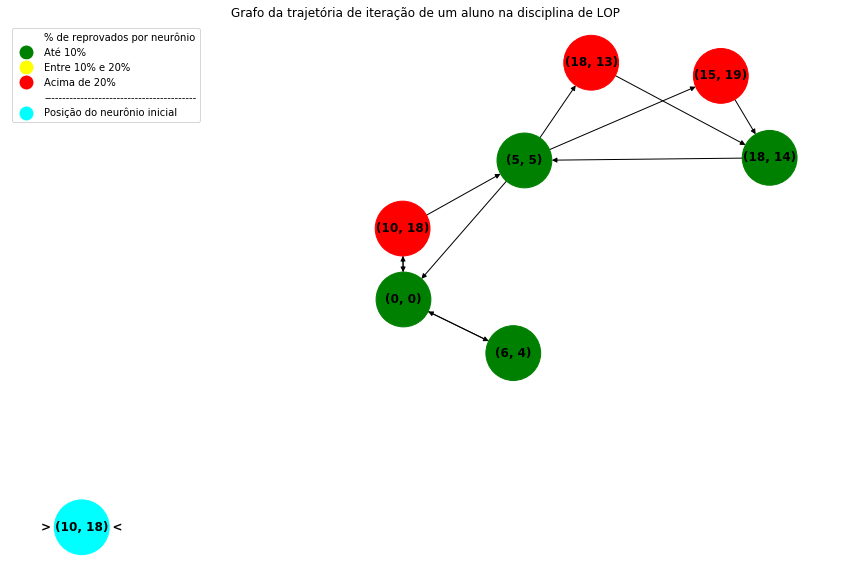

In [0]:
Grafo = criaGrafo(X_train,18)

In [0]:
verificaSemanasNoNeuronio(Grafo,0,0)

Semana(s) que caíram no neurônio [5, 8, 10, 16]


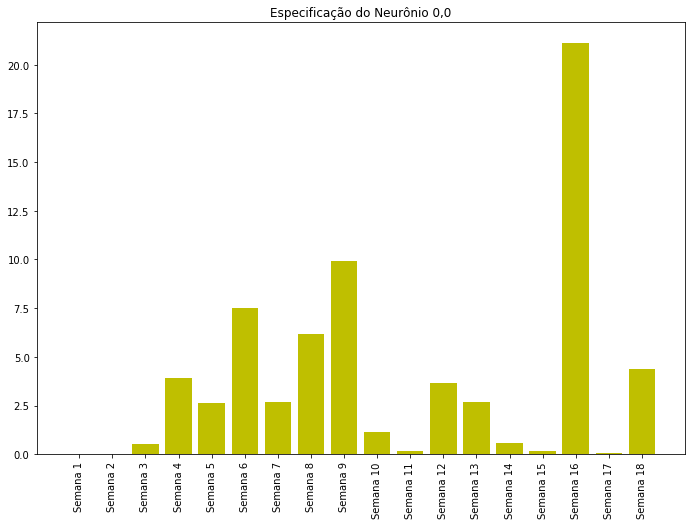

In [0]:
exibeNeuronio(0,0) 

Gráfico de superfície

In [32]:
chamaGraficoDeSuperficie(MContRe)

Gráfico de Pizza das situações 

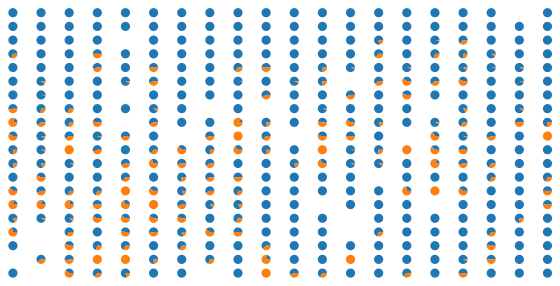

In [45]:
chamaGraficoDePizzaDeSituacoes()

#resto

Função pra gerar o campo dos vencedores

In [0]:
def criaColunaVencedores(table1,table2):
  for i in range(1,19):
    table1["Vencedor semana "+str(i)] = 0
    table2["Vencedor semana "+str(i)] = 0
  table1["user"]=0
  table2["user"]=0
  return (table1,table2)

Escolhendo um caso específico para verificar o desempenho

In [0]:
aluno = tab.loc[tab["idAluno"]=="5991cd870be9d42f2f68b90c",:]
aluno = aluno.iloc[:,44:62].values

BomDesempenho = np.zeros((tamanhoXdaRede,tamanhoYdaRede))

cont = 0

for x in range(tamanhoXdaRede): 
  pos = som.winner(x)    
  BomDesempenho[pos] += 1
print(BomDesempenho)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0. 15.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

#resto 2

In [0]:
x_train = tab.iloc[:, 3:7].values

In [0]:
cont = 1;
#MContRe = np.zeros((tamanhoXdaRede,tamanhoYdaRede))
matriz = np.zeros((tamanhoXdaRede,tamanhoXdaRede))
for i in range(len(MContRe)):
  for j in range(len(MContRe)):
    matriz[i][j] = MContRe[i][j]/MContT[i][j]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


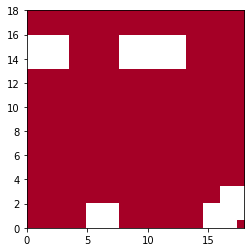

In [0]:
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

delta = 0.025
#x = y = np.arange(-3.0, 3.0, delta)
#X, Y = np.meshgrid(x, y)
#Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
#Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
#Z = Z2 - Z1  # difference of Gaussians

im = plt.imshow(matriz, interpolation='bilinear', cmap=cm.RdYlGn,
                origin='lower', extent=[0, 18, 0, 18],
                vmax=abs(matriz).max(), vmin=-abs(matriz).max())

plt.show()

Função para exibir um neurônio específico

In [0]:
def exibeNeuronio(linha,coluna): 
  x = tab.columns()
  plt.plot([-1,18])
  #plt.axis([-1, 18, 0, 35])
  plt.bar(x, pesos[linha,coluna,:])
  plt.show()

#Parte2

Função para deixar em uma linha 

In [0]:
def limpaConcatenaLinhas(table1,table2):
  table1.replace(np.nan, 0, inplace=True)   
  table1 = table1.groupby(["user"]).sum()
  table2.replace(np.nan, 0, inplace=True)   
  table2 = table2.groupby(["user"]).sum()
  return (table1,table2)

Função para separar em um dfx e um dfy os vencedores da SOM

In [0]:
def separaXeYdosVencedores():
  cont = 1
  user = 1

  dfx = pd.DataFrame()
  dfy = pd.DataFrame()
  (dfx,dfy) = criaColunaVencedores(dfx,dfy)

  for i in X_train:
    pos = som.winner(i)
    arraybi = np.asarray(pos)
    if(cont == 19):
        cont = 1
        user = user + 1
    dfx = dfx.append({dfx.columns[cont-1]:arraybi[0],"user":user}, ignore_index=True)
    dfy = dfy.append({dfy.columns[cont-1]:arraybi[1],"user":user}, ignore_index=True)  
    cont = cont + 1
  (dfx,dfy) = limpaConcatenaLinhas(dfx,dfy)  
  return(dfx,dfy)

Chamada das função de separar o X e o Y dos vencedores por semana em dataframes

In [0]:
(vencedorX,vencedorY) = separaXeYdosVencedores()

In [0]:
vencedorX.head(2)

,Vencedor semana 1,Vencedor semana 2,Vencedor semana 3,Vencedor semana 4,Vencedor semana 5,Vencedor semana 6,Vencedor semana 7,Vencedor semana 8,Vencedor semana 9,Vencedor semana 10,Vencedor semana 11,Vencedor semana 12,Vencedor semana 13,Vencedor semana 14,Vencedor semana 15,Vencedor semana 16,Vencedor semana 17,Vencedor semana 18
user,,,,,,,,,,,,,,,,,,
1.0,0.0,2.0,3.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,0.0,2.0
2.0,2.0,0.0,0.0,4.0,7.0,5.0,7.0,7.0,0.0,7.0,7.0,7.0,7.0,4.0,7.0,0.0,5.0,7.0


In [0]:
vencedorY.head(2)

,Vencedor semana 1,Vencedor semana 2,Vencedor semana 3,Vencedor semana 4,Vencedor semana 5,Vencedor semana 6,Vencedor semana 7,Vencedor semana 8,Vencedor semana 9,Vencedor semana 10,Vencedor semana 11,Vencedor semana 12,Vencedor semana 13,Vencedor semana 14,Vencedor semana 15,Vencedor semana 16,Vencedor semana 17,Vencedor semana 18
user,,,,,,,,,,,,,,,,,,
1.0,9.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,3.0,9.0,3.0,9.0,1.0,8.0,2.0,1.0,3.0,1.0
2.0,1.0,3.0,3.0,8.0,6.0,7.0,6.0,6.0,9.0,6.0,6.0,6.0,6.0,8.0,6.0,9.0,7.0,6.0


In [0]:
vency = vencedorY.iloc[1000,1:].values
vencx = vencedorX.iloc[1000,1:].values

In [0]:
print(vencx)
print(vency)

[9. 2. 9. 2. 2. 9. 2. 2. 6. 9. 2. 2. 5. 2. 9. 2. 2.]
[9. 4. 9. 4. 4. 9. 4. 4. 4. 9. 4. 4. 5. 3. 9. 3. 4.]


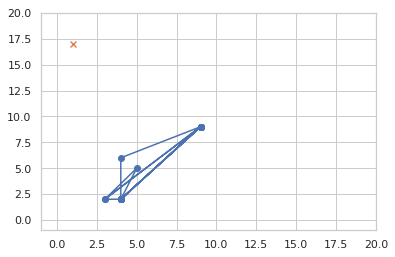

In [0]:
plt.plot(vency,vencx)
plt.scatter(vency,vencx)
plt.scatter(1,17,marker="x")
plt.axis([-1,20,-1,20])
plt.show()

Gera CSV'S

In [0]:
vencedorX.to_csv("vencedorX.csv")
vencedorY.to_csv("vencedorY.csv")

In [0]:
X_train[3][2]

0.0

In [0]:
X_test = X_train[50]

In [0]:
X_test

array([ 0.,  0.,  0.,  5.,  0.,  5.,  0., 14.,  2.,  0.,  0.,  4.,  0.,
        5.,  0.,  0.,  0.,  0.])

In [0]:
print(MContT.astype(int))

[[ 276  442    0 5468   95  208  284   48   36  132]
 [ 127  430  516  406  117  206   99  185   75    4]
 [ 223  218  132  216  328  196  151  105   60   81]
 [ 296  497   97   98  205  165   43  187  112    0]
 [ 201  174  369  141   61  133  177   63   10   40]
 [  84  164   20  182   51  146    5   50   30    0]
 [  79  117   60   77    2  322   50   85   15  128]
 [ 267   60   42  105   14  179   44   20  275  136]
 [  93   44  121   53   67   59   93  212   29   80]
 [ 148  101  233  154   73   54  104  183  183   95]]


In [0]:
aluno = tab.loc[tab["idAluno"]=="5ace43c6e1b024040e6845f0",:]
aluno = aluno.iloc[:,44:62]
aluno

In [0]:
aluno = tab.loc[tab["idAluno"]=="5ace43c6e1b024040e6845f0",:]
aluno = aluno.iloc[:,44:62].values

BomDesempenho = np.zeros((tamanhoXdaRede,tamanhoYdaRede))

cont = 0

for x in range(0,1): 
  pos = som.winner(x)    
  BomDesempenho[pos] += 1
print(BomDesempenho)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [0]:
print(MContT)

[[ 158.  149.  152.  506.  134. 5418.  126.  497.  295.  226.]
 [   0.    8.  203.  127.   61.  440.   70.   91.  189.  153.]
 [  96.   76.   38.  238.  203.  177.  238.  275.  121.  235.]
 [  16.   12.  206.  126.   21.  149.  469.  300.  115.   92.]
 [ 191.   75.  109.   96.   84.  394.  135.  262.  120.  178.]
 [ 128.   24.  120.   47.  249.   46.  172.    0.  152.  106.]
 [  99.   64.   89.   84.   48.   35.   90.   40.    0.  100.]
 [  78.  177.   46.   98.  116.   47.  114.    0.  176.   87.]
 [  75.    0.  144.   54.  198.   94.   78.  212.   84.  109.]
 [ 114.   30.  184.  199.  289.  139.   41.  194.   63.  138.]]


In [0]:
tab.describe()

,nota,submissões diferentes e iguais a 100% semana 1,submissões diferentes e iguais a 100% semana 2,submissões diferentes e iguais a 100% semana 3,submissões diferentes e iguais a 100% semana 4,submissões diferentes e iguais a 100% semana 5,submissões diferentes e iguais a 100% semana 6,submissões diferentes e iguais a 100% semana 7,submissões diferentes e iguais a 100% semana 8,submissões diferentes e iguais a 100% semana 9,submissões diferentes e iguais a 100% semana 10,submissões diferentes e iguais a 100% semana 11,submissões diferentes e iguais a 100% semana 12,submissões diferentes e iguais a 100% semana 13,submissões diferentes e iguais a 100% semana 14,submissões diferentes e iguais a 100% semana 15,submissões diferentes e iguais a 100% semana 16,submissões diferentes e iguais a 100% semana 17,submissões diferentes e iguais a 100% semana 18
count,18921.000000,18921.0,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000,18921.000000
mean,5.847392,0.0,0.019026,0.781248,1.266212,1.899371,1.419798,1.838433,2.284869,2.668569,1.426352,0.512182,0.562338,0.596956,0.589821,0.460229,0.459807,0.162518,0.155172
std,3.079472,0.0,0.415932,3.038596,3.598318,3.981952,3.316071,3.937911,4.553769,5.838618,4.187351,1.978043,1.927007,2.106674,2.035644,1.920160,1.989025,1.231743,1.281855
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.700000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.600000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.300000,0.0,0.000000,0.000000,1.000000,2.000000,1.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,0.0,10.000000,34.000000,62.000000,30.000000,28.000000,33.000000,31.000000,71.000000,50.000000,30.000000,23.000000,33.000000,33.000000,20.000000,31.000000,35.000000,30.000000


In [0]:
tab.loc[tab["submissões diferentes e iguais a 100% semana 9"] == 71,:]

,idAluno,nota,situacao,submissões diferentes e iguais a 100% semana 1,submissões diferentes e iguais a 100% semana 2,submissões diferentes e iguais a 100% semana 3,submissões diferentes e iguais a 100% semana 4,submissões diferentes e iguais a 100% semana 5,submissões diferentes e iguais a 100% semana 6,submissões diferentes e iguais a 100% semana 7,submissões diferentes e iguais a 100% semana 8,submissões diferentes e iguais a 100% semana 9,submissões diferentes e iguais a 100% semana 10,submissões diferentes e iguais a 100% semana 11,submissões diferentes e iguais a 100% semana 12,submissões diferentes e iguais a 100% semana 13,submissões diferentes e iguais a 100% semana 14,submissões diferentes e iguais a 100% semana 15,submissões diferentes e iguais a 100% semana 16,submissões diferentes e iguais a 100% semana 17,submissões diferentes e iguais a 100% semana 18
9891,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9892,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9894,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9896,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9897,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9898,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9899,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9903,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9904,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9905,5ace43c6e1b024040e6845f0,8.5,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
a=tab.iloc[:,:4]
a

,idAluno,nota,situacao,submissões diferentes e iguais a 100% semana 1
0,5991cb910be9d42f2f68b906,7.9,APROVADO,0.0
1,5991cb910be9d42f2f68b906,7.9,APROVADO,0.0
2,5991cb910be9d42f2f68b906,7.9,APROVADO,0.0
3,5991cb910be9d42f2f68b906,7.9,APROVADO,0.0
4,5991cb910be9d42f2f68b906,7.9,APROVADO,0.0
...,...,...,...,...
22507,5d4ec939c1853254c20afd44,0.0,REPROVADO POR MÉDIA E POR FALTAS,0.0
22508,5d4ec939c1853254c20afd44,0.0,REPROVADO POR MÉDIA E POR FALTAS,0.0
22509,5d4ec939c1853254c20afd44,0.0,REPROVADO POR MÉDIA E POR FALTAS,0.0
22510,5d4ec939c1853254c20afd44,0.0,REPROVADO POR MÉDIA E POR FALTAS,0.0


In [0]:
a.loc[a["submissões diferentes e iguais a 100% semana 1"] > 0,:]


,idAluno,nota,situacao,submissões diferentes e iguais a 100% semana 1


In [0]:
tab.loc[tab["idAluno"]=="5991cd870be9d42f2f68b90c",:]

,idAluno,nota,situacao,submissões diferentes e iguais a 100% semana 1,submissões diferentes e iguais a 100% semana 2,submissões diferentes e iguais a 100% semana 3,submissões diferentes e iguais a 100% semana 4,submissões diferentes e iguais a 100% semana 5,submissões diferentes e iguais a 100% semana 6,submissões diferentes e iguais a 100% semana 7,submissões diferentes e iguais a 100% semana 8,submissões diferentes e iguais a 100% semana 9,submissões diferentes e iguais a 100% semana 10,submissões diferentes e iguais a 100% semana 11,submissões diferentes e iguais a 100% semana 12,submissões diferentes e iguais a 100% semana 13,submissões diferentes e iguais a 100% semana 14,submissões diferentes e iguais a 100% semana 15,submissões diferentes e iguais a 100% semana 16,submissões diferentes e iguais a 100% semana 17,submissões diferentes e iguais a 100% semana 18
462,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,5.0,14.0,15.0,4.0,10.0,0.0,0.0,4.0,20.0,6.0,0.0,9.0,0.0,0.0,0.0
463,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,5.0,14.0,15.0,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
465,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,5.0,14.0,15.0,4.0,10.0,0.0,0.0,4.0,20.0,6.0,0.0,0.0,0.0,0.0,0.0
466,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,5.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
468,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,5.0,14.0,15.0,4.0,10.0,0.0,0.0,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
469,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,5.0,14.0,15.0,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
470,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,5.0,14.0,15.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
471,5991cd870be9d42f2f68b90c,10.0,APROVADO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
